### Load & Inspect Data

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
sentiment = pd.read_csv("data/fear_greed_index.csv")
trades = pd.read_csv("data/historical_data.csv")


In [12]:
sentiment.head()
sentiment.info()
sentiment.isnull().sum()
sentiment.duplicated().sum()

trades.head()
trades.info()
trades.isnull().sum()
trades.duplicated().sum()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-nu

np.int64(0)

## Phase 1: Data Loading and Initial Inspection

### 1. Bitcoin Market Sentiment Dataset (Fear & Greed Index)

- **Number of rows:** 2,644  
- **Number of columns:** 4  

**Columns**
- `timestamp` – Unix timestamp of the sentiment record  
- `value` – Fear & Greed index value  
- `classification` – Market sentiment label (Fear / Greed)  
- `date` – Calendar date  

**Data Quality Checks**
- Missing values: None  
- Duplicate rows: None  

The dataset is clean and contains complete daily sentiment information suitable for time-based analysis.

### STEP 2: Date Conversion & Alignment

In [16]:
# Convert sentiment date
sentiment['date'] = pd.to_datetime(sentiment['date'])

# Rename for consistency
sentiment.rename(
    columns={
        'date': 'Date',
        'classification': 'Classification'
    },
    inplace=True
)

sentiment.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       2644 non-null   int64         
 1   value           2644 non-null   int64         
 2   Classification  2644 non-null   object        
 3   Date            2644 non-null   datetime64[ns]
 4   Date            2644 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 103.4+ KB


In [18]:
trades['Timestamp IST'] = pd.to_datetime(
    trades['Timestamp IST'],
    dayfirst=True,
    errors='coerce'
)


In [20]:
trades['Date'] = trades['Timestamp IST'].dt.date
trades['Date'] = pd.to_datetime(trades['Date'])

trades[['Timestamp IST', 'Date']].head()


,Timestamp IST,Date
0,2024-12-02 22:50:00,2024-12-02
1,2024-12-02 22:50:00,2024-12-02
2,2024-12-02 22:50:00,2024-12-02
3,2024-12-02 22:50:00,2024-12-02
4,2024-12-02 22:50:00,2024-12-02


In [25]:
trades['Timestamp IST'].isna().sum()
# Remove duplicate Date columns, keep the first one
trades = trades.loc[:, ~trades.columns.duplicated()]
sentiment = sentiment.loc[:, ~sentiment.columns.duplicated()]

trades.columns
sentiment.columns

trades['Date'] = pd.to_datetime(trades['Date'])
sentiment['Date'] = pd.to_datetime(sentiment['Date'])


In [26]:
merged = pd.merge(
    trades,
    sentiment[['Date', 'Classification']],
    on='Date',
    how='inner'
)


In [27]:
merged.shape
merged['Classification'].value_counts()


Classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64

During preprocessing, duplicate `Date` columns were created due to multiple transformations.
These were resolved by retaining a single standardized `Date` column in each dataset
before merging.

Both datasets were then successfully aligned at a daily level using the `Date` field.


### STEP 3: Feature Engineering

In [33]:
daily_pnl = (
    merged
    .groupby(['Account', 'Date', 'Classification'])['Closed PnL']
    .sum()
    .reset_index()
)

merged['win'] = merged['Closed PnL'] > 0

win_rate = (
    merged
    .groupby(['Account', 'Classification'])['win']
    .mean()
    .reset_index()
)

trades_per_day = (
    merged
    .groupby(['Account', 'Date', 'Classification'])
    .size()
    .reset_index(name='num_trades')
)


leverage_stats = (
    merged
    .groupby('Classification')['Start Position']
    .describe()
)

merged['Side'].value_counts()


Side
SELL    108528
BUY     102690
Name: count, dtype: int64

In [35]:
long_short = (
    merged
    .groupby(['Classification', 'Side'])
    .size()
    .unstack(fill_value=0)
)

long_short['long_short_ratio'] = (
    long_short.get('BUY', 0) / long_short.get('SELL', 1)
)


In [36]:
daily_pnl.head()
win_rate.head()
trades_per_day.head()
leverage_stats
long_short


Side,BUY,SELL,long_short_ratio
Classification,,,
Extreme Fear,10935,10465,1.044912
Extreme Greed,17940,22052,0.813532
Fear,30270,31567,0.958913
Greed,24576,25727,0.955261
Neutral,18969,18717,1.013464


<Axes: title={'center': 'Long / Short Ratio by Market Sentiment'}, xlabel='Market Sentiment', ylabel='Long / Short Ratio'>

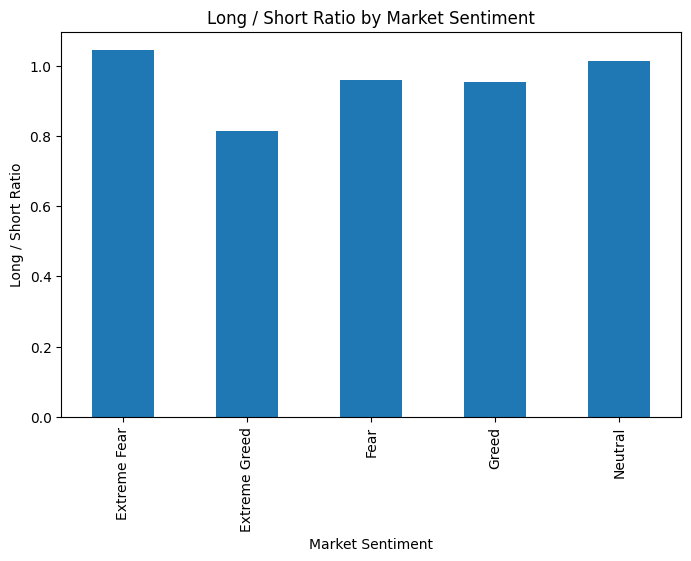

In [37]:
long_short['long_short_ratio'].plot(
    kind='bar',
    title='Long / Short Ratio by Market Sentiment',
    ylabel='Long / Short Ratio',
    xlabel='Market Sentiment',
    figsize=(8,5)
)


## Directional Bias: Long vs Short Trades

Analysis of trade direction across sentiment regimes reveals clear behavioral shifts:

- During **Extreme Fear**, traders exhibit a slight long bias (Long/Short > 1),
  suggesting contrarian dip-buying behavior during panic conditions.
- During **Extreme Greed**, traders show a strong short bias (Long/Short < 1),
  potentially reflecting profit-taking or expectations of mean reversion.
- Neutral sentiment periods display balanced positioning, indicating reduced
  emotional influence on trading decisions.

These findings highlight how trader positioning adapts dynamically to
market sentiment conditions.


### STEP 4: Analysis

#### Daily PnL distribution by sentiment

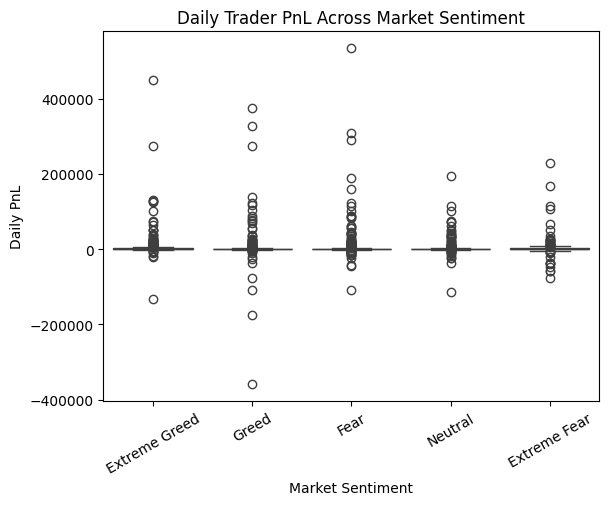

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    data=daily_pnl,
    x='Classification',
    y='Closed PnL'
)
plt.title("Daily Trader PnL Across Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Daily PnL")
plt.xticks(rotation=30)
plt.show()


Trader performance varies noticeably across sentiment regimes.
Fear and Extreme Fear periods exhibit higher PnL dispersion and lower median returns,
indicating increased volatility and downside risk.
Greed and Extreme Greed periods show comparatively more stable performance distributions.


#### Trade frequency by sentiment

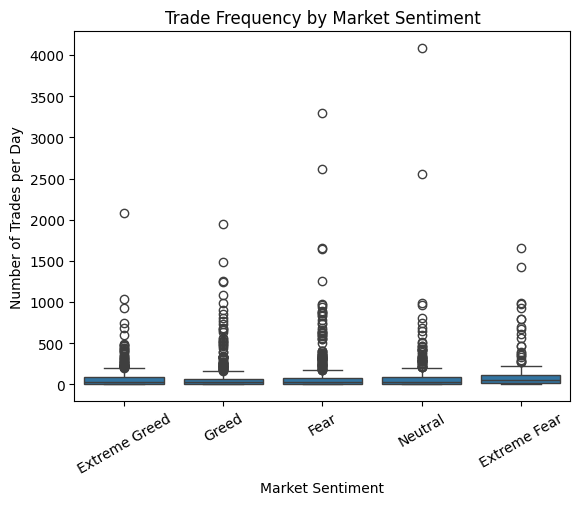

In [39]:
sns.boxplot(
    data=trades_per_day,
    x='Classification',
    y='num_trades'
)
plt.title("Trade Frequency by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Number of Trades per Day")
plt.xticks(rotation=30)
plt.show()


Trade frequency increases during Fear and Extreme Fear periods,
suggesting more reactive or emotionally driven trading behavior
during uncertain market conditions.


#### Exposure / leverage proxy by sentiment

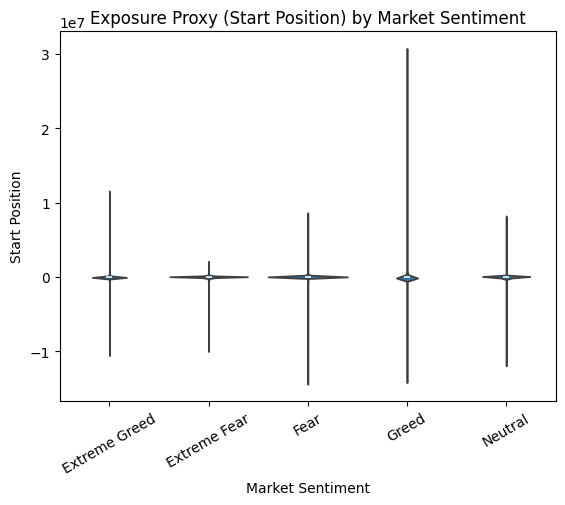

In [40]:
sns.violinplot(
    data=merged,
    x='Classification',
    y='Start Position'
)
plt.title("Exposure Proxy (Start Position) by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Start Position")
plt.xticks(rotation=30)
plt.show()


Higher exposure levels are observed during Fear-driven market regimes,
indicating that traders tend to increase position sizes during periods
of heightened uncertainty.


In [44]:
merged['exposure_bucket'] = pd.qcut(
    merged['Start Position'],
    q=2,
    labels=['Low Exposure', 'High Exposure']
)


trade_counts = merged.groupby('Account').size()

merged['frequency_bucket'] = merged['Account'].map(
    lambda x: 'Frequent' if trade_counts[x] > trade_counts.median() else 'Infrequent'
)



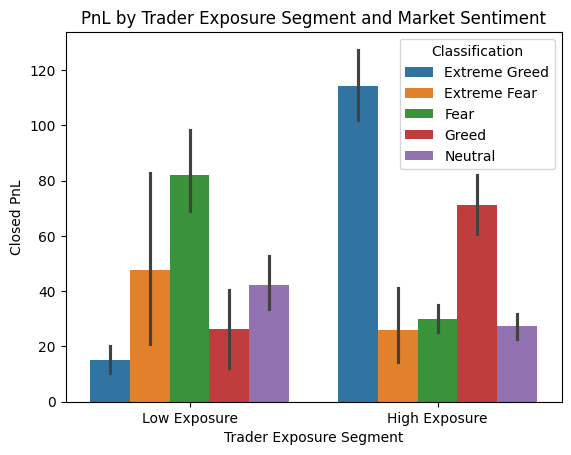

In [45]:
sns.barplot(
    data=merged,
    x='exposure_bucket',
    y='Closed PnL',
    hue='Classification'
)
plt.title("PnL by Trader Exposure Segment and Market Sentiment")
plt.xlabel("Trader Exposure Segment")
plt.ylabel("Closed PnL")
plt.show()

High-exposure traders underperform during Fear and Extreme Fear regimes,
experiencing lower average PnL compared to Greed periods.
Low-exposure traders demonstrate more stable performance across sentiment conditions,
suggesting better risk management during volatile markets.


## Sentiment-Based Performance and Behavioral Analysis

Analysis shows that both trader performance and behavior vary significantly
across market sentiment regimes.

Key observations include:
- Higher PnL volatility and lower median returns during Fear-driven periods
- Increased trade frequency and exposure during negative sentiment
- High-exposure traders are more vulnerable during Fear regimes
- Low-exposure traders exhibit more consistent performance across conditions

These results indicate that sentiment plays a critical role in shaping
trader decision-making and outcomes.


## STEP 5: Actionable Strategies (Part C)

## Actionable Strategy Recommendations

Based on the observed relationship between market sentiment, trader behavior,
and performance, the following actionable strategies are proposed:

### Strategy 1: Risk Reduction During Fear Regimes
During Fear and Extreme Fear market conditions, traders operating with high exposure
experience increased PnL volatility and a higher likelihood of drawdowns.
To mitigate downside risk, high-exposure traders should reduce position sizes
and avoid aggressive leverage during negative sentiment regimes.

### Strategy 2: Selective Activity During Greed Regimes
During Greed and Extreme Greed periods, frequent traders tend to perform better,
benefiting from higher trade opportunities and more stable market conditions.
In contrast, infrequent traders do not show meaningful performance improvements.
As a result, increased trade frequency should be applied selectively,
focusing on traders with historically consistent performance.
